## Generación personalizada de una tabla LUT para estimación de SpO₂

Este notebook construye una tabla de búsqueda (LUT, Look-Up Table) personalizada para estimar la saturación de oxígeno (SpO₂) en función del ratio óptico \( R \) calculado a partir de señales PPG (IR y RED). A diferencia de una fórmula empírica lineal, aquí se emplean datos reales etiquetados para aprender una correspondencia directa entre ratio y SpO₂, basada en observaciones.

### Flujo del algoritmo:

1. **Carga de señales**
   - Se recorren múltiples archivos .csv que contienen señales corregidas por luz ambiente (IR - AMB_IR y RED - AMB_RED).
   - Se descartan registros con valores no válidos (por ejemplo, si las componentes AC o DC son nulas).

2. **Cálculo del ratio óptico**
   - Para cada archivo, se calcula el ratio clásico.
   - Se multiplica por 100 y se redondea para usarlo como índice en una tabla.

3. **Construcción de la tabla SpO2**
   - Se agrupan los valores de SpO2 reales (extraídos del nombre del archivo) por cada índice de ratio.
   - Se calcula el promedio de SpO2 para cada índice.
   - Se rellenan los huecos mediante interpolación lineal para asegurar una tabla continua.

4. **Visualización de la tabla LUT**
   - Se representa gráficamente la relación ratio → SpO2 basada en datos reales, diferenciando los puntos interpolados de los valores medidos.

5. **Estimación de SpO2 a partir de la tabla**
   - Se aplica la LUT a cada archivo y se imprime el valor estimado de SpO2 para su ratio correspondiente.

6. **Visualización adicional**
   - Se muestra una ventana de 10 segundos de una señal corregida IR, para observar su comportamiento morfológico.

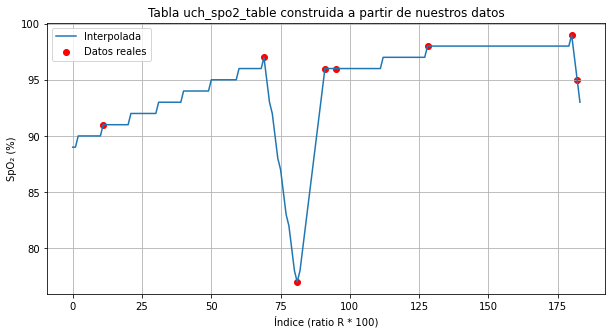

In [4]:
import pandas as pd
import os
import re
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

ruta = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos_limpios"
archivos = [f for f in os.listdir(ruta) if f.endswith(".csv")]

ratios_dict = defaultdict(list)

for archivo in archivos:
    match = re.search(r'(\d+)_\d+\.csv', archivo)  # Extrae el SpO2 externo
    if match:
        spo2_ext = int(match.group(1))
        try:
            df = pd.read_csv(os.path.join(ruta, archivo))
            ir = df["IR"] - df["AMB_IR"]
            red = df["RED"] - df["AMB_RED"]

            ac_ir = ir.max() - ir.min()
            dc_ir = ir.mean()
            ac_red = red.max() - red.min()
            dc_red = red.mean()

            if all(val > 0 for val in [ac_ir, dc_ir, ac_red, dc_red]):
                ratio = (ac_red / dc_red) / (ac_ir / dc_ir)
                index = int(ratio * 100)
                if 0 <= index < 184:
                    ratios_dict[index].append(spo2_ext)
        except Exception as e:
            print(f"{archivo}: ERROR {e}")

# Crear tabla a partir del promedio por índice
tabla_spo2 = [0] * 184
for idx in range(184):
    if ratios_dict[idx]:
        tabla_spo2[idx] = int(np.mean(ratios_dict[idx]))

# Interpolación para rellenar huecos
x_known = [i for i, val in enumerate(tabla_spo2) if val > 0]
y_known = [val for val in tabla_spo2 if val > 0]

interp_func = interp1d(x_known, y_known, kind='linear', fill_value="extrapolate")
tabla_spo2_interp = [int(np.clip(interp_func(i), 70, 100)) for i in range(184)]

# Visualizar la tabla construida
plt.figure(figsize=(10, 5))
plt.plot(tabla_spo2_interp, label="Interpolada")
plt.scatter(x_known, y_known, color='red', label="Datos reales")
plt.xlabel("Índice (ratio R * 100)")
plt.ylabel("SpO₂ (%)")
plt.title("Tabla uch_spo2_table construida a partir de nuestros datos")
plt.grid(True)
plt.legend()
plt.show()


In [5]:
def estimar_spo2(ratio, tabla):
    index = int(ratio * 100)
    index = np.clip(index, 0, len(tabla) - 1)
    return tabla[index]

print("\n--- Estimación de SpO₂ usando tabla propia ---\n")
for archivo in archivos:
    try:
        df = pd.read_csv(os.path.join(ruta, archivo))
        ir = df["IR"] - df["AMB_IR"]
        red = df["RED"] - df["AMB_RED"]

        ac_ir = ir.max() - ir.min()
        dc_ir = ir.mean()
        ac_red = red.max() - red.min()
        dc_red = red.mean()

        if all(val > 0 for val in [ac_ir, dc_ir, ac_red, dc_red]):
            ratio = (ac_red / dc_red) / (ac_ir / dc_ir)
            spo2_estimado = estimar_spo2(ratio, tabla_spo2_interp)
            print(f"{archivo:40s} → R = {ratio:.3f} → SpO₂ estimado = {spo2_estimado}%")
        else:
            print(f"{archivo:40s} → Señal no válida")
    except Exception as e:
        print(f"{archivo:40s} → ERROR: {e}")



--- Estimación de SpO₂ usando tabla propia ---

raw_data_91_91.csv                       → R = 0.117 → SpO₂ estimado = 91%
raw_data_92_76.csv                       → R = 11.906 → SpO₂ estimado = 93%
raw_data_93_100.csv                      → Señal no válida
raw_data_95_77_2.csv                     → R = 0.816 → SpO₂ estimado = 77%
raw_data_95_80.csv                       → R = 2.604 → SpO₂ estimado = 93%
raw_data_95_81_papa.csv                  → R = 0.538 → SpO₂ estimado = 95%
raw_data_95_99.csv                       → R = 1.826 → SpO₂ estimado = 95%
raw_data_96_106.csv                      → R = 0.957 → SpO₂ estimado = 96%
raw_data_96_69.csv                       → R = 0.912 → SpO₂ estimado = 96%
raw_data_97_119.csv                      → R = 0.695 → SpO₂ estimado = 97%
raw_data_97_95.csv                       → R = 16.143 → SpO₂ estimado = 93%
raw_data_98_81.csv                       → R = 4.252 → SpO₂ estimado = 93%
raw_data_98_86.csv                       → Señal no válida
raw_da


--- Estimación de SpO₂ usando tabla propia ---

raw_data_91_91.csv                       → R = 0.117 → SpO₂ estimado = 91%
raw_data_92_76.csv                       → R = 11.906 → SpO₂ estimado = 93%
raw_data_93_100.csv                      → Señal no válida
raw_data_95_77_2.csv                     → R = 0.816 → SpO₂ estimado = 77%
raw_data_95_80.csv                       → R = 2.604 → SpO₂ estimado = 93%
raw_data_95_81_papa.csv                  → R = 0.538 → SpO₂ estimado = 95%
raw_data_95_99.csv                       → R = 1.826 → SpO₂ estimado = 95%
raw_data_96_106.csv                      → R = 0.957 → SpO₂ estimado = 96%
raw_data_96_69.csv                       → R = 0.912 → SpO₂ estimado = 96%
raw_data_97_119.csv                      → R = 0.695 → SpO₂ estimado = 97%
raw_data_97_95.csv                       → R = 16.143 → SpO₂ estimado = 93%
raw_data_98_81.csv                       → R = 4.252 → SpO₂ estimado = 93%
raw_data_98_86.csv                       → Señal no válida
raw_da

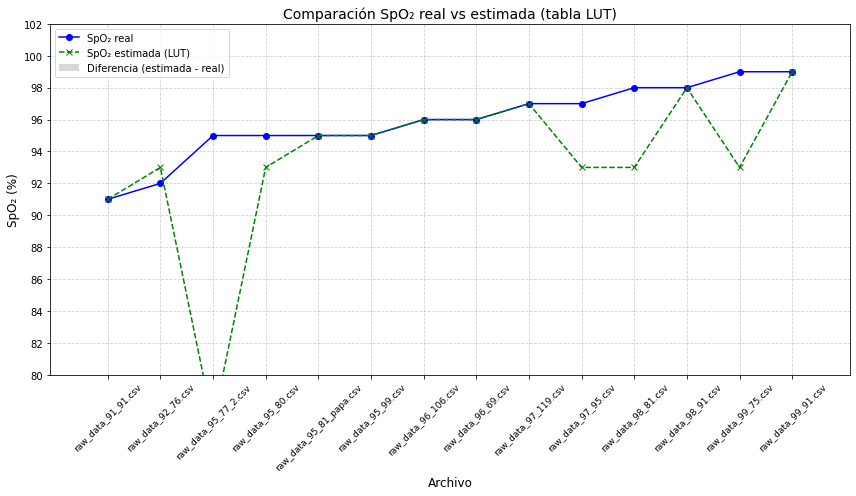

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os

# Inicializar listas para el gráfico
real_vals = []
estimados = []
archivos_validos = []

# Ruta de salida
ruta_salida = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados\SpO2"

print("\n--- Estimación de SpO₂ usando tabla propia ---\n")
for archivo in archivos:
    try:
        df = pd.read_csv(os.path.join(ruta, archivo))
        ir = df["IR"] - df["AMB_IR"]
        red = df["RED"] - df["AMB_RED"]

        ac_ir = ir.max() - ir.min()
        dc_ir = ir.mean()
        ac_red = red.max() - red.min()
        dc_red = red.mean()

        if all(val > 0 for val in [ac_ir, dc_ir, ac_red, dc_red]):
            ratio = (ac_red / dc_red) / (ac_ir / dc_ir)
            spo2_estimado = estimar_spo2(ratio, tabla_spo2_interp)

            # Obtener SpO2 real desde el nombre
            match = re.match(r"raw_data_(\d+)_\d+", archivo)
            if match:
                spo2_real = int(match.group(1))
                real_vals.append(spo2_real)
                estimados.append(spo2_estimado)
                archivos_validos.append(archivo)

            print(f"{archivo:40s} → R = {ratio:.3f} → SpO₂ estimado = {spo2_estimado}%")
        else:
            print(f"{archivo:40s} → Señal no válida")
    except Exception as e:
        print(f"{archivo:40s} → ERROR: {e}")

# Graficar resultados
if real_vals and estimados:
    indices = range(1, len(real_vals) + 1)
    errores = np.array(estimados) - np.array(real_vals)

    plt.figure(figsize=(12, 7))
    plt.plot(indices, real_vals, label="SpO₂ real", marker='o', color='blue')
    plt.plot(indices, estimados, label="SpO₂ estimada (LUT)", marker='x', linestyle='--', color='green')
    plt.bar(indices, errores, alpha=0.3, color='gray', label="Diferencia (estimada - real)")

    plt.title("Comparación SpO₂ real vs estimada (tabla LUT)", fontsize=14)
    plt.xlabel("Archivo", fontsize=12)
    plt.ylabel("SpO₂ (%)", fontsize=12)
    plt.xticks(indices, archivos_validos, rotation=45, fontsize=9)
    plt.yticks(np.arange(80, 105, 2))
    plt.ylim(80, 102)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()

    ruta_img = os.path.join(ruta_salida, "grafico_spo2_lut.png")
    plt.savefig(ruta_img)
    print(f"\nGráfico guardado en: {ruta_img}")
    plt.show()
else:
    print("No hay datos válidos para graficar.")
